# Dataset

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Libraries and packages

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import json
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sn
from math import log, inf
sn.set()
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from operator import itemgetter
from sklearn.model_selection import train_test_split

In [22]:
def plot_confusion_matrix(confusion_matrix, title='', cmap ='Greens'):
    df = pd.DataFrame(confusion_matrix, range(len(confusion_matrix)), range(len(confusion_matrix)))
    plt.figure(figsize=(12,8))
    if title == '' :
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix' + ' ' + title)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 12},fmt='.0f',cmap=cmap) # font size
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# DataProcessor

In [4]:
class DataProcessor():

  def __init__(self, stopwords_path, punctuations_path):
    with open(stopwords_path, 'r') as f:
      stopwords = list(set(f.read().splitlines()))
      self.stopwords_dict = Counter(stopwords)

    with open(punctuations_path, 'r') as f:
      self.punctuations = list(set(f.read().splitlines()))

  def read_data(self, data_path):
    return pd.read_csv(data_path, encoding = "utf-8-sig",on_bad_lines='skip')

  def split_data(self, df, test_size=0.25, text_col='Text', Label='Topic', shuffle=True):
    X_train, X_test, y_train, y_test = train_test_split(df[[text_col]], df[Label], test_size=test_size, shuffle=shuffle, stratify=df[[Label]])
    le = LabelEncoder().fit(y_train.ravel())
    y_train = le.transform(y_train.ravel())
    y_test = le.transform(y_test.ravel())
    # return X_train, X_test, y_train, y_test, y_train.unique()
    return X_train, X_test, y_train, y_test, le.classes_

  def clean_text(self, text, remove_punctuations=True):
    if remove_punctuations:
      for punc in self.punctuations:
        text = text.replace(punc, ' ')
    text = re.sub('\d+\.\d+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s*[A-Za-z]+\b', ' ' , text).strip()
    text = re.sub(' +', ' ', ' '.join([word for word in text.split() if word not in self.stopwords_dict]))
    return re.sub(' +', ' ', text)


# NaiveBayesClassifier

In [29]:
class NaiveBayesClassifier():

    def __init__(self, categories):
        self.word_frequencies = {}
        self.categories = categories

    def count_word_per_class(self, array_texts, array_labels, most_frequent_export_path='frequent.txt'):
      for index, text in tqdm(enumerate(array_texts)):
        tokens = text.split(' ')
        for token in tokens:
          if token in self.word_frequencies:
              self.word_frequencies[token][array_labels[index]] += 1
          else:
              self.word_frequencies[token] = np.zeros(len(self.categories), int)
              self.word_frequencies[token][array_labels[index]] += 1

      self.word_frequencies = dict(sorted(self.word_frequencies.items(), key=lambda item: sum(item[1]), reverse=True))
      self.total_num_words = len(self.word_frequencies)
      self.total_per_class = np.sum(list(self.word_frequencies.values()), axis=0)

      n_unique_token, n_total_token = len(self.word_frequencies), sum(self.word_frequencies.values())
      most_frequent_words = dict(itertools.islice(self.word_frequencies.items(), 200))

      for index, category in enumerate(self.categories):
        print(f'Total number of words in {category} category : {self.total_per_class[index]}')

      with open(most_frequent_export_path, 'w', encoding='utf8') as f:
        f.write(f"Number of whole tokens: {n_total_token}\n")
        f.write(f"Number of unique tokens: {n_unique_token}\n")
        f.write("Most frequent words are :\n")
        for key, value in most_frequent_words.items():
            f.write(f"{key} : {sum(value)}\n")
      return self.word_frequencies

    def __calculate_word_log_prob_per_class(self, word):
      return np.log((self.word_frequencies.get(word, 0) + 1) / (self.total_per_class + self.total_num_words))

    def calculate_log_prior(self, array_category):
      unique, counts = np.unique(array_category, return_counts=True)
      return np.log(counts / len(unique))

    def predict(self, text, log_prior, verbose=False):
      probs = np.zeros(len(self.categories), dtype=float)
      tokens = text.split()
      for word in tokens:
        if not probs is None:
          probs += self.__calculate_word_log_prob_per_class(word)
      probs += log_prior
      if verbose:
        for index, category in enumerate(self.categories):
          print(f'probability for {category} category: {probs[index]}')

      return probs, np.argmax(probs)

    def evaluate(self, y_true, y_pred):
      plot_confusion_matrix(confusion_matrix(y_true, y_pred))
      print('----------------------------------')
      print(classification_report(y_true, y_pred, target_names=self.categories))



### Load and Process Data

In [6]:
import pandas as pd
dataset = pd.read_csv('gdrive/MyDrive/Event Detection from Twitter/Event Detection Final Dataset/TrendDetection_Final_Dataset_Processed.csv')
dataset = dataset.loc[:, ['text','Topic']].reset_index(drop=True)
dataset.head()

,text,Topic
0,تظاهرات حمایت از گروههای مجاهدین در کابل,Social
1,افتتاح دو بیمارستان، با سفر کرزی به مزارشریف,Social
2,گفتگو با بنیامین، خواننده پاپ ایران,Art
3,در یک نگاه: نامزدهای جایزه اسکار بهترین فیلم,Art
4,آیاتحریم‌های خارجی می‌تواند بر صنعت نفت ایران ...,Industry


In [7]:
data_processor = DataProcessor(stopwords_path='/content/stopwords.txt',
                               punctuations_path='/content/punctuation.txt')

In [8]:
X_train, X_test, y_train, y_test, categories = data_processor.split_data(dataset,
                                                                         test_size=0.40,
                                                                         text_col='text',
                                                                         Label='Topic',
                                                                         shuffle=True)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'Categories: {categories}')

X_train shape: (980179, 1)
y_train shape: (980179,)
X_test shape: (653454, 1)
y_test shape: (653454,)
Categories: ['Art' 'Celebrity' 'Crypto' 'Economy' 'Environment' 'Game' 'Health'
 'Industry' 'Politics' 'Social' 'Sport' 'Technology']


In [9]:
X_train['text'] = X_train['text'].apply(data_processor.clean_text)
X_test['text'] = X_test['text'].apply(data_processor.clean_text)

### Model Training

In [30]:
nb_clf = NaiveBayesClassifier(categories)
_ = nb_clf.count_word_per_class(X_train['text'].to_numpy(),
                                y_train,
                                most_frequent_export_path='frequent.txt')


980179it [00:24, 40122.71it/s]


Total number of words in Art category : 1177446
Total number of words in Celebrity category : 591581
Total number of words in Crypto category : 524859
Total number of words in Economy category : 1070816
Total number of words in Environment category : 703341
Total number of words in Game category : 473371
Total number of words in Health category : 1176488
Total number of words in Industry category : 817626
Total number of words in Politics category : 430967
Total number of words in Social category : 3684633
Total number of words in Sport category : 1243616
Total number of words in Technology category : 1877754


In [31]:
log_prior = nb_clf.calculate_log_prior(y_train)
log_prior

array([8.7057453 , 7.89986442, 7.82787202, 8.66143783, 8.07716252,
       7.99333861, 8.50351676, 8.17824122, 7.40493826, 9.74051264,
       9.42814972, 9.8477634 ])

### Evaluation

In [32]:
predictions = np.zeros(len(y_test), int)
for index, text in tqdm(enumerate(X_test['text'].to_numpy())):
  predictions[index] = nb_clf.predict(text, log_prior)[-1]

653454it [01:26, 7525.34it/s] 


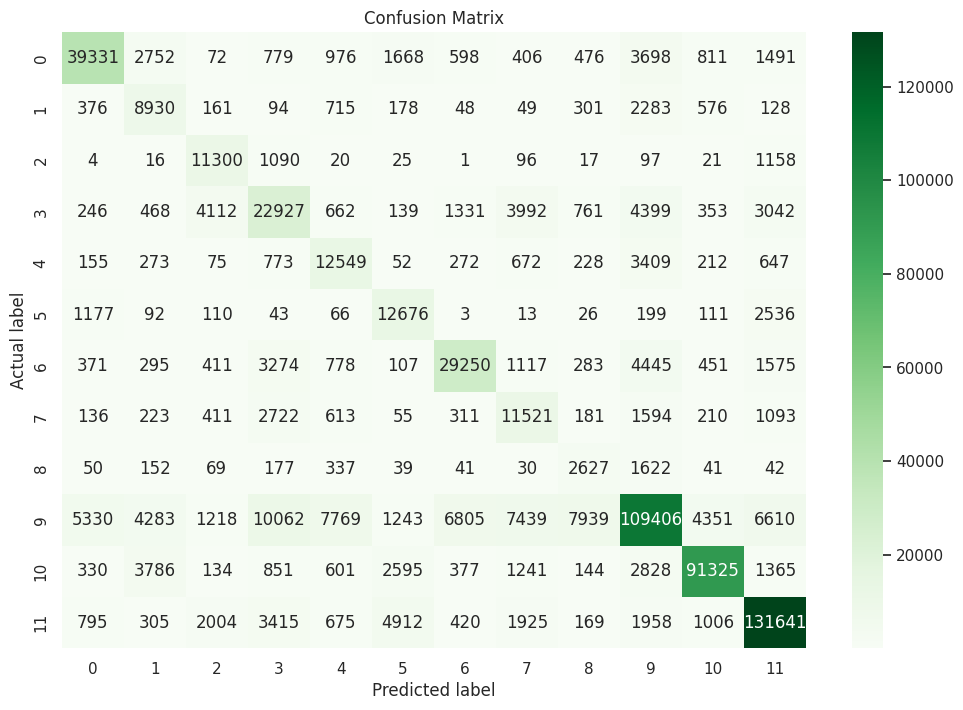

----------------------------------
              precision    recall  f1-score   support

         Art       0.81      0.74      0.78     53058
   Celebrity       0.41      0.65      0.50     13839
      Crypto       0.56      0.82      0.67     13845
     Economy       0.50      0.54      0.52     42432
 Environment       0.49      0.65      0.56     19317
        Game       0.54      0.74      0.62     17052
      Health       0.74      0.69      0.72     42357
    Industry       0.40      0.60      0.48     19070
    Politics       0.20      0.50      0.29      5227
      Social       0.80      0.63      0.71    172455
       Sport       0.92      0.87      0.89    105577
  Technology       0.87      0.88      0.88    149225

    accuracy                           0.74    653454
   macro avg       0.60      0.69      0.63    653454
weighted avg       0.77      0.74      0.75    653454



In [36]:
nb_clf.evaluate(predictions, y_test)